In [1]:
import numpy as np
import pandas as pd
import os
from bambi import Model

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from plotting_functions import plot_correlation, cm2inch
from analysis_functions import compute_gaze_influence_score, compute_mean_rt, compute_p_choose_best
from analysis_functions import make_sure_path_exists
from analysis_functions import q1, q3, iqr, std, se, add_best_chosen

In [2]:
np.random.seed(52) # from random.org

# Data I/O

In [3]:
# load all data and divide in even / odd
all_data = pd.read_csv('data/data_aggregate.csv')
even = all_data[(all_data['trial'] % 2) == 0].reset_index(drop=True)
odd = all_data[(all_data['trial'] % 2) == 1].reset_index(drop=True)

In [4]:
# load prediction daat
prediction_multiplicative_list = []
prediction_nobias_list = []

# join prediction dataframes
for subject in odd['subject'].unique():
    subject_pred_multiplicative = pd.read_csv(os.path.join('results', 'predictions', 'out_of_sample', 'multiplicative', 'prediction_{}_multiplicative_oos.csv'.format(subject)), index_col=0)
    subject_pred_nobias = pd.read_csv(os.path.join('results', 'predictions', 'out_of_sample', 'nobias', 'prediction_{}_nobias_oos.csv'.format(subject)), index_col=0)
    subject_pred_multiplicative['subject'] = subject
    subject_pred_nobias['subject'] = subject

    prediction_multiplicative_list.append(subject_pred_multiplicative)
    prediction_nobias_list.append(subject_pred_nobias)

prediction_multiplicative = pd.concat(prediction_multiplicative_list)
prediction_nobias = pd.concat(prediction_nobias_list)

/Users/armin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/armin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [5]:
# discard trials with negative predicted RT
prediction_multiplicative = prediction_multiplicative[prediction_multiplicative['rt'] > 0].copy()
prediction_nobias = prediction_nobias[prediction_nobias['rt'] > 0].copy()

# Compute behavioral indices for observed data and predictions

In [6]:
def aggregate_subject_level(data, n_items):
    """
    Aggregates a single dataset to subject level
    """
    data = data.copy()
    
    # add best chosen variable
    data = add_best_chosen(data)
    
    # Summarize variables
    subject_summary = data.groupby('subject').agg({'rt': ['mean', std, 'min', 'max', se, q1, q3, iqr],
                                                   'best_chosen': 'mean'})
    # Influence of gaze on P(choice | value)
    subject_summary['gaze_influence'] = compute_gaze_influence_score(data, n_items=n_items)
    
    subject_summary['dataset'] = data.groupby('subject')['dataset'].head(1).values
    
    return subject_summary

In [7]:
# compute behavioral indices
odd_summary_list = []
pred_multiplicative_summary_list = []
pred_nobias_summary_list = []

for di, dataset in enumerate(odd['dataset'].unique()):
    odd_di = odd[odd['dataset'] == dataset].copy()
    n_items = odd_di['n_items'].unique()[0]

    odd_summary_di = aggregate_subject_level(odd_di, n_items=n_items)

    prediction_multiplicative_di = prediction_multiplicative[prediction_multiplicative['dataset'] == dataset].copy()
    prediction_nobias_di = prediction_nobias[prediction_nobias['dataset'] == dataset].copy()

    pred_multiplicative_summary_di = aggregate_subject_level(prediction_multiplicative_di, n_items=n_items)
    pred_nobias_summary_di = aggregate_subject_level(prediction_nobias_di, n_items=n_items)


    odd_summary_list.append(odd_summary_di)
    pred_multiplicative_summary_list.append(pred_multiplicative_summary_di)
    pred_nobias_summary_list.append(pred_nobias_summary_di)

odd_summary = pd.concat(odd_summary_list)
pred_multiplicative_summary = pd.concat(pred_multiplicative_summary_list)
pred_nobias_summary = pd.concat(pred_nobias_summary_list)

In [8]:
# save files, if not existing
odd_oos_summary_path = os.path.join('results', 'predictions', 'out_of_sample', 'descriptives',
                                                'subject_summary_odd_oos.csv')
multiplicative_oos_summary_path = os.path.join('results', 'predictions', 'out_of_sample', 'descriptives',
                                                'subject_summary_multiplicative_oos.csv')
nobias_oos_summary_path = os.path.join('results', 'predictions', 'out_of_sample', 'descriptives',
                                        'subject_summary_nobias_oos.csv')

if not os.path.isfile(odd_oos_summary_path):
    odd_summary.to_csv(odd_oos_summary_path)
if not os.path.isfile(multiplicative_oos_summary_path):
    pred_multiplicative_summary.to_csv(multiplicative_oos_summary_path)
if not os.path.isfile(nobias_oos_summary_path):
    pred_nobias_summary.to_csv(nobias_oos_summary_path)

In [9]:
pred_nobias_summary.head()

rt                                                   \
                mean          std    min      max         se       q1   
subject                                                                 
0        1483.665778   535.686925  471.0   4115.0  11.295782  1117.25   
1        1502.737959   642.897107  423.0   4639.0  12.991134  1062.25   
2        4427.150800  2895.781847  664.0  28717.0  57.927224  2411.75   
3        1921.084545   504.680828  838.0   4738.0  10.762278  1617.75   
4        1740.098400   794.662275  500.0   5851.0  15.896425  1198.00   

                          best_chosen gaze_influence       dataset  
              q3      iqr        mean                               
subject                                                             
0        1733.00   615.75    0.890222      -0.002591  krajbich2010  
1        1790.75   728.50    0.780000       0.047497  krajbich2010  
2        5542.50  3130.75    0.846400       0.015188  krajbich2010  
3        2145.00   527.25    0.688636      -0.009199  krajbich2010  
4        2084.00   886.00    0.840800      -0.009003  krajbich2010

In [10]:
pred_multiplicative_summary.tail()

rt                                                          \
                mean          std    min      max         se      q1      q3   
subject                                                                        
113      2189.337197  2153.038110  286.0  17284.0  12.665149  1144.0  2389.0   
114      3341.584506  4984.396269  289.0  40259.0  27.691518  1380.0  3250.0   
115      1271.193815  1127.552996  243.0   9399.0   7.145720   771.0  1353.0   
116      2420.559574  2655.438637  317.0  21727.0  14.640130  1248.0  2556.0   
117      1458.849035   823.192480  267.0   6268.0   4.555819   944.0  1716.0   

                best_chosen gaze_influence      dataset  
            iqr        mean                              
subject                                                  
113      1245.0    0.855052       0.213650  tavares2017  
114      1870.0    0.826173       0.149680  tavares2017  
115       582.0    0.865663       0.287849  tavares2017  
116      1308.0    0.833769       0.326199  tavares2017  
117       772.0    0.770567       0.160005  tavares2017

# Mixed effects analysis of prediction biases

In [11]:
n_samples = 20000

## GLAM

In [12]:
# Reformat data for mixed model
mean_rt = np.concatenate([odd_summary['rt']['mean'].values,
                          pred_multiplicative_summary['rt']['mean'].values],
                         axis=0)
best_chosen = np.concatenate([odd_summary['best_chosen']['mean'].values,
                              pred_multiplicative_summary['best_chosen']['mean'].values],
                             axis=0)
gaze_influence = np.concatenate([odd_summary['gaze_influence'].values,
                                 pred_multiplicative_summary['gaze_influence'].values],
                                axis=0)

is_pred = np.concatenate([np.zeros(len(odd_summary)),
                          np.ones(len(pred_multiplicative_summary))],
                         axis=0)
dataset = np.concatenate([odd_summary['dataset'].values,
                          pred_multiplicative_summary['dataset'].values],
                         axis=0)

df = pd.DataFrame(dict(mean_rt=mean_rt,
                       best_chosen=best_chosen,
                       gaze_influence=gaze_influence,
                       is_pred=is_pred,
                       dataset=dataset))

df.head()

,best_chosen,dataset,gaze_influence,is_pred,mean_rt
0,0.822222,krajbich2010,-0.020529,0.0,1704.177778
1,0.673469,krajbich2010,0.247233,0.0,1728.489796
2,0.840000,krajbich2010,0.028877,0.0,4078.660000
3,0.704545,krajbich2010,-0.022031,0.0,1893.545455
4,0.840000,krajbich2010,0.103622,0.0,1846.640000


In [13]:
result_file = os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_glam_rt.csv')
if not os.path.isfile(result_file):
    results_mean_rt = model.fit('mean_rt ~ is_pred',
                                random=['is_pred|dataset'],
                                categorical=['dataset'],
                                samples=n_samples)

    bias_analysis_glam_mean_rt = results_mean_rt.summary(ranefs=True)
    bias_analysis_glam_mean_rt.to_csv(result_file)
else:
    bias_analysis_glam_mean_rt = pd.read_csv(result_file)
bias_analysis_glam_mean_rt

,Unnamed: 0,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
0,is_pred|dataset[folke2016],6.183238,193.424643,-418.517774,439.787199,2793,1.000765
1,is_pred|dataset[krajbich2010],-13.927032,181.691662,-425.657753,376.940723,2220,1.001247
2,is_pred|dataset[krajbich2011],-15.680129,189.891561,-454.574960,390.925857,2408,1.000426
3,is_pred|dataset[tavares2017],9.238693,194.331711,-414.882331,443.869557,2276,1.000827
4,is_pred|dataset_sd,226.660761,251.766992,0.016741,686.596580,1047,1.002964
5,is_pred,-9.132202,183.321313,-409.726087,344.452495,1592,1.002040
6,Intercept,2944.900317,743.890997,1488.746634,4416.812658,1052,1.002927
7,1|dataset[folke2016],2370.965658,751.982456,948.822934,3931.385639,1118,1.002462
8,1|dataset[krajbich2010],-781.187041,748.869686,-2221.514423,752.620702,1086,1.002634
9,1|dataset[krajbich2011],-521.260399,750.008881,-2026.287790,944.050806,1107,1.002577


In [14]:
result_file = os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_glam_best_chosen.csv')
if not os.path.isfile(result_file):
    results_best_chosen = model.fit('best_chosen ~ is_pred',
                                    random=['is_pred|dataset'],
                                    categorical=['dataset'],
                                    samples=n_samples)

    bias_analysis_glam_best_chosen = results_best_chosen.summary(ranefs=True)
    bias_analysis_glam_best_chosen.to_csv(result_file)
else:
    bias_analysis_glam_best_chosen = pd.read_csv(result_file)
bias_analysis_glam_best_chosen

,Unnamed: 0,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
0,is_pred|dataset[folke2016],-0.006850,0.025211,-6.294348e-02,0.042713,14227,1.000141
1,is_pred|dataset[krajbich2010],0.010806,0.025016,-3.388074e-02,0.068218,12820,0.999994
2,is_pred|dataset[krajbich2011],-0.008073,0.025001,-6.704170e-02,0.036807,13663,1.000039
3,is_pred|dataset[tavares2017],0.003912,0.024995,-4.385866e-02,0.061252,13825,1.000016
4,is_pred|dataset_sd,0.029641,0.031191,6.969388e-07,0.088930,8430,0.999975
5,is_pred,-0.022139,0.023374,-7.026238e-02,0.023049,12781,1.000022
6,Intercept,0.767203,0.051055,6.602676e-01,0.868185,7143,1.000083
7,1|dataset[folke2016],-0.110091,0.052479,-2.205632e-01,-0.007200,7728,1.000155
8,1|dataset[krajbich2010],0.050345,0.051821,-5.546481e-02,0.154463,6947,1.000062
9,1|dataset[krajbich2011],-0.031545,0.052142,-1.387941e-01,0.072376,7432,1.000085


In [15]:
result_file = os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_glam_gaze.csv')
if not os.path.isfile(result_file):
    model = Model(df)
    results_gaze_influence = model.fit('gaze_influence ~ is_pred',
                                       random=['is_pred|dataset'],
                                       categorical=['dataset'],
                                       samples=n_samples)

    bias_analysis_glam_gaze_influence = results_gaze_influence.summary(ranefs=True)
    bias_analysis_glam_gaze_influence.to_csv(result_file)
else:
    bias_analysis_glam_gaze_influence = pd.read_csv(result_file)
bias_analysis_glam_gaze_influence

,Unnamed: 0,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
0,is_pred|dataset[folke2016],0.005786,0.035830,-5.896349e-02,0.082816,548,1.002607
1,is_pred|dataset[krajbich2010],-0.009886,0.036081,-8.436952e-02,0.052604,429,1.004118
2,is_pred|dataset[krajbich2011],-0.000542,0.035602,-6.562848e-02,0.070636,396,1.003242
3,is_pred|dataset[tavares2017],-0.000806,0.035546,-6.716548e-02,0.074427,454,1.002978
4,is_pred|dataset_sd,0.035896,0.043408,5.817650e-07,0.112897,390,1.001424
5,gaze_influence_sd,0.143388,0.005333,1.340886e-01,0.152977,17016,1.000082
6,is_pred,-0.022051,0.035455,-8.253339e-02,0.042121,431,1.003064
7,Intercept,0.240041,0.047946,1.449192e-01,0.340855,765,1.004340
8,1|dataset[folke2016],0.081390,0.051597,-1.977554e-02,0.186141,813,1.004182
9,1|dataset[krajbich2010],-0.039964,0.049367,-1.455025e-01,0.056396,855,1.003416


## No Bias

In [16]:
# Prepare data for mixed model
mean_rt = np.concatenate([odd_summary['rt']['mean'].values,
                          pred_nobias_summary['rt']['mean'].values],
                         axis=0)
best_chosen = np.concatenate([odd_summary['best_chosen']['mean'].values,
                              pred_nobias_summary['best_chosen']['mean'].values],
                             axis=0)
gaze_influence = np.concatenate([odd_summary['gaze_influence'].values,
                                 pred_nobias_summary['gaze_influence'].values],
                                axis=0)

is_pred = np.concatenate([np.zeros(len(odd_summary)),
                          np.ones(len(pred_nobias_summary))],
                         axis=0)
dataset = np.concatenate([odd_summary['dataset'].values,
                          pred_nobias_summary['dataset'].values],
                         axis=0)

df = pd.DataFrame(dict(mean_rt=mean_rt,
                       best_chosen=best_chosen,
                       gaze_influence=gaze_influence,
                       is_pred=is_pred,
                       dataset=dataset))

df.head()

,best_chosen,dataset,gaze_influence,is_pred,mean_rt
0,0.822222,krajbich2010,-0.020529,0.0,1704.177778
1,0.673469,krajbich2010,0.247233,0.0,1728.489796
2,0.840000,krajbich2010,0.028877,0.0,4078.660000
3,0.704545,krajbich2010,-0.022031,0.0,1893.545455
4,0.840000,krajbich2010,0.103622,0.0,1846.640000


In [17]:
result_file = os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_nobias_rt.csv')
if not os.path.isfile(result_file):
    results_mean_rt = model.fit('mean_rt ~ is_pred',
                                random=['is_pred|dataset'],
                                categorical=['dataset'],
                                samples=n_samples)
    bias_analysis_nobias_mean_rt = results_mean_rt.summary(ranefs=True)
    bias_analysis_nobias_mean_rt.to_csv(result_file)
else:
    bias_analysis_nobias_mean_rt = pd.read_csv(result_file)
bias_analysis_nobias_mean_rt

,Unnamed: 0,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
0,is_pred|dataset[folke2016],-2.526226,195.730639,-442.559707,419.515893,5191,1.000126
1,is_pred|dataset[krajbich2010],-17.880493,184.558756,-431.111345,369.979637,3924,1.000357
2,is_pred|dataset[krajbich2011],5.378380,189.572513,-407.977578,422.470261,4321,1.000615
3,is_pred|dataset[tavares2017],5.896717,193.936155,-413.332875,443.886545,4985,1.000215
4,is_pred|dataset_sd,227.115535,246.036493,0.000107,691.711755,2288,0.999977
5,is_pred,14.652198,185.818392,-354.925326,412.874884,2788,1.001059
6,Intercept,2930.310779,795.489915,1289.818888,4439.705363,923,1.000255
7,1|dataset[folke2016],2374.522983,804.441179,828.028235,4005.160960,966,1.000341
8,1|dataset[krajbich2010],-771.767522,800.579567,-2365.051578,796.446894,948,1.000307
9,1|dataset[krajbich2011],-487.608329,802.376406,-2062.665692,1115.052138,948,1.000252


In [18]:
result_file = os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_nobias_best_chosen.csv')
if not os.path.isfile(result_file):
    results_best_chosen = model.fit('best_chosen ~ is_pred',
                                    random=['is_pred|dataset'],
                                    categorical=['dataset'],
                                    samples=n_samples)
    bias_analysis_nobias_best_chosen = results_best_chosen.summary(ranefs=True)
    bias_analysis_nobias_best_chosen.to_csv(result_file)
else:
    bias_analysis_nobias_best_chosen = pd.read_csv(result_file)
bias_analysis_nobias_best_chosen

,Unnamed: 0,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
0,is_pred|dataset[folke2016],-0.009518,0.024767,-0.067449,0.034684,10982,0.999993
1,is_pred|dataset[krajbich2010],0.014496,0.025427,-0.030271,0.072145,7709,0.999977
2,is_pred|dataset[krajbich2011],-0.003072,0.023852,-0.054723,0.046599,8274,1.000024
3,is_pred|dataset[tavares2017],-0.001081,0.024223,-0.052884,0.051231,8060,0.999978
4,is_pred|dataset_sd,0.029804,0.029438,0.000001,0.088121,7866,0.999981
5,is_pred,0.001294,0.022764,-0.044332,0.048286,7507,0.999988
6,Intercept,0.769141,0.049428,0.669974,0.869689,7060,0.999981
7,1|dataset[folke2016],-0.113719,0.050585,-0.214910,-0.011406,7618,0.999978
8,1|dataset[krajbich2010],0.049531,0.050381,-0.050653,0.152601,7309,0.999980
9,1|dataset[krajbich2011],-0.030279,0.050391,-0.132406,0.071070,7459,1.000000


In [19]:
result_file = os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_nobias_gaze.csv')
if not os.path.isfile(result_file):
    model = Model(df)
    results_gaze_influence = model.fit('gaze_influence ~ is_pred',
                                       random=['is_pred|dataset'],
                                       categorical=['dataset'],
                                       samples=n_samples)
    bias_analysis_nobias_gaze_influence = results_gaze_influence.summary(ranefs=True)
    bias_analysis_nobias_gaze_influence.to_csv(result_file)
else:
    bias_analysis_nobias_gaze_influence = pd.read_csv(result_file)
bias_analysis_nobias_gaze_influence

,Unnamed: 0,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
0,is_pred|dataset[folke2016],-0.064004,0.052485,-0.175414,0.022771,1838,1.000588
1,is_pred|dataset[krajbich2010],0.015505,0.042666,-0.078539,0.105360,2085,1.000359
2,is_pred|dataset[krajbich2011],-0.010303,0.043774,-0.109497,0.075273,1854,1.000669
3,is_pred|dataset[tavares2017],0.017728,0.043824,-0.075261,0.111455,2190,1.000292
4,is_pred|dataset_sd,0.068428,0.048503,0.000006,0.164987,2123,1.000267
5,gaze_influence_sd,0.108833,0.005229,0.098903,0.119399,40000,1.000112
6,is_pred,-0.227179,0.041045,-0.308115,-0.131912,1640,1.000545
7,Intercept,0.236765,0.036684,0.156990,0.311178,1972,1.001390
8,1|dataset[folke2016],0.069280,0.041886,-0.005757,0.161977,3436,1.000709
9,1|dataset[krajbich2010],-0.029083,0.038281,-0.109351,0.049900,2128,1.001224


# Figure 5

In [20]:
def figure_5(observed, multiplicative, nobias,
             figsize=cm2inch(18,11), colors=None, fontsize=7, alpha=1.0):

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']
    
    if colors is None:
        colors = np.array(['C{}'.format(i)
                           for i in range(observed['dataset'].unique().size)])
    color_idx = pd.Categorical(observed['dataset'], categories=datasets, ordered=True).codes.astype(int)
    
    fig, axs = plt.subplots(2, 3, figsize=figsize)
    
    for m, model in enumerate([multiplicative, nobias]):

        # a) Mean RT
        axs[m, 0].scatter(observed['rt']['mean'],
                          model['rt']['mean'],
                          marker='o',
                          color='none',
                          edgecolor=colors[color_idx],
                          linewidth=0.5,
                          s=30)
        axs[m, 0].scatter(observed['rt']['mean'],
                          model['rt']['mean'],
                          marker='o',
                          color=colors[color_idx],
                          alpha=0.5,
                          linewidth=0,
                          s=30)
        axs[m, 0].set_xticks(np.arange(0, 10000, 2000))
        axs[m, 0].set_yticks(np.arange(0, 10000, 2000))
        axs[m, 0].set_xlim(0, 9000)
        axs[m, 0].set_ylim(0, 9000)
        
        # b) P(choose best)
        axs[m, 1].scatter(observed['best_chosen']['mean'],
                          model['best_chosen']['mean'],
                          marker='o',
                          color='none',
                          edgecolor=colors[color_idx],
                          linewidth=0.5,
                          s=30)
        axs[m, 1].scatter(observed['best_chosen']['mean'],
                          model['best_chosen']['mean'],
                          marker='o',
                          color=colors[color_idx],
                          alpha=0.5,
                          linewidth=0,
                          s=30)
        axs[m, 1].set_xticks(np.arange(0.4, 1.1, 0.2))
        axs[m, 1].set_yticks(np.arange(0.4, 1.1, 0.2))
        axs[m, 1].set_xlim(0.3, 1.0)
        axs[m, 1].set_ylim(0.3, 1.0)

        # c) Gaze Influence
        axs[m, 2].scatter(observed['gaze_influence'],
                          model['gaze_influence'],
                          marker='o',
                          color='none',
                          edgecolor=colors[color_idx],
                          linewidth=0.5,
                          s=30)
        axs[m, 2].scatter(observed['gaze_influence'],
                          model['gaze_influence'],
                          marker='o',
                          color=colors[color_idx],
                          alpha=0.5,
                          linewidth=0,
                          s=30)
        axs[m, 2].set_xticks(np.arange(-0.2, 1.1, 0.2))
        axs[m, 2].set_yticks(np.arange(-0.2, 1.1, 0.2))
        axs[m, 2].set_xlim(-0.25, 0.85)
        axs[m, 2].set_ylim(-0.25, 0.85)

    axs[0, 0].set_ylabel('GLAM\n\nPredicted Mean RT (ms)', fontsize=fontsize)
    axs[1, 0].set_ylabel('No-Bias\n\nPredicted Mean RT (ms)', fontsize=fontsize)
    axs[0, 0].set_xlabel('Observed Mean RT (ms)', fontsize=fontsize)
    axs[1, 0].set_xlabel('Observed Mean RT (ms)', fontsize=fontsize)
    
    axs[0, 1].set_ylabel('Predicted P(choose best)', fontsize=fontsize)
    axs[1, 1].set_ylabel('Predicted P(choose best)', fontsize=fontsize)
    axs[0, 1].set_xlabel('Observed P(choose best)', fontsize=fontsize)
    axs[1, 1].set_xlabel('Observed P(choose best)', fontsize=fontsize)
    
    axs[0, 2].set_ylabel('Predicted Gaze Influence\non P(choice | value)', fontsize=fontsize)
    axs[1, 2].set_ylabel('Predicted Gaze Influence\non P(choice | value)', fontsize=fontsize)
    axs[0, 2].set_xlabel('Observed Gaze Influence\non P(choice | value)', fontsize=fontsize)
    axs[1, 2].set_xlabel('Observed Gaze Influence\non P(choice | value)', fontsize=fontsize)
    
    patches = [mpatches.Rectangle((0, 0), 0.5, 1, fc="C{}".format(i))
               for i in range(len(datasets))]

    axs[0, 0].legend(patches,
                     ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                     loc='upper left',
                     handlelength=1, handleheight=1,
                     fontsize=5,
                     frameon=False)

    # Labels
    for label, ax in zip(list('abcdef'), axs.ravel()):
        ax.text(-0.4, 1.1, label, transform=ax.transAxes,
                fontsize=fontsize, fontweight='bold', va='top')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Font sizes
        ax.tick_params(axis='both', labelsize=fontsize)

        # Plot diagonal
        ax.plot(ax.get_xlim(), ax.get_xlim(), linewidth=1, color='black', alpha=1.0, zorder=-1)
        
    fig.tight_layout(pad=2)

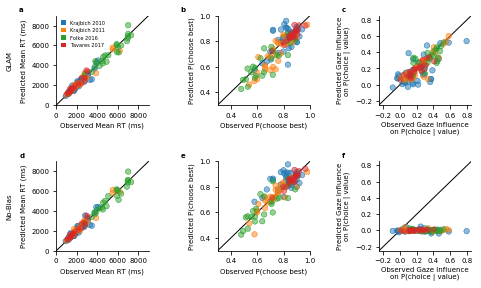

In [21]:
figure_5(odd_summary, pred_multiplicative_summary, pred_nobias_summary, alpha=1);
plt.savefig('results/figures/figure_5_absolute_model_fit.png', dpi=330, bbox_inches='tight')
plt.savefig('results/figures/figure_5_absolute_model_fit.pdf', dpi=330, bbox_inches='tight')
plt.show()